In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

2022-08-30 15:02:02.390557: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class CategoryMap:
  def __init__(self, dataset_json):
    with open(dataset_json) as json_file:
      data = json.load(json_file)

    category2idx = {}
    idx2category = {}
    category2name = {}
    category_list = []

    categories = pd.DataFrame(data['annotations'])['category_id'].unique()
    categories = sorted(categories)
    for idx, category in enumerate(categories):
      category2idx[category] = idx
      idx2category[idx] = category
      category_list.append(category)

    category2name = {cat['id']: cat['name'] for cat in data['categories']
                      if cat['id'] in category_list}

    self.category2idx = category2idx
    self.idx2category = idx2category
    self.category2name = category2name
    self.num_classes = len(self.category2idx)
    self.category_list = category_list

  def category_to_index(self, category):
    return self.category2idx[category]

  def index_to_category(self, index):
    return self.idx2category[index]

  def category_to_name(self, category):
    return self.category2name[category]

  def get_category_list(self):
    return self.category_list

  def get_num_classes(self):
    return self.num_classes

def _load_metadata(dataset_json, category_map, default_empty_label=0):
    with tf.io.gfile.GFile(dataset_json, 'r') as json_file:
        json_data = json.load(json_file)
    images = pd.DataFrame(json_data['images'])
    if 'annotations' in json_data.keys():
        annotations = pd.DataFrame(json_data['annotations'])
        images = pd.merge(images,
                        annotations[["image_id", "category_id"]],
                        how='left',
                        left_on='id',
                        right_on='image_id')
    else:
        images['category_id'] = default_empty_label

    images['category_id'] = images['category_id'].apply(
                                          category_map.category_to_index)

    return images

def load_instances_per_class(json_data):
    category_map = CategoryMap(json_data)
    metadata = _load_metadata(json_data, category_map)
    instances_per_cls = dict(metadata['category_id'].value_counts())

    return instances_per_cls

In [3]:
def _load_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data

def load_results_to_df(json_results_patern):
    if isinstance(json_results_patern, list):
        json_files = []
        for patern in json_results_patern:
            json_files += tf.io.gfile.glob(patern)
    else:
        json_files = tf.io.gfile.glob(json_results_patern)
    
    results = [_load_json(jfile) for jfile in json_files]

    return pd.DataFrame(results)

def format_results(df):
    df = pd.concat([df.drop(['acc_bins'], axis=1),
                      df['acc_bins'].apply(pd.Series).add_prefix('acc_')],
                     axis=1)
    df = df[['dataset', 'model', 'training_setup', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all', 'f1_score_cls']]
    df[['acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all']] = (df[['acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all']]*100).round(2)
    
    training_setup_name = {'repre': 'Baseline', 'crt': 'Square-root Resampling', 'cbfocal': 'CBFocal', 'bags': 'BAGS', 'ssb': 'SSB (Ours)'}
    df['training_setup'] = df['training_setup'].map(training_setup_name)
    
    model_name = {'effv2b2': 'EfficientNetV2-B2', 'swin-s': 'Swin-S', 'resnet50': 'Resnet50', 'mbnetv3': 'MobileNetV3Large'}
    df['model'] = df['model'].map(model_name)
    
    dataset_name = {'serengeti': 'SS', 'wellington': 'Wellington', 'wcs': 'WCS', 'caltech': 'Caltech'}
    df['dataset'] = df['dataset'].map(dataset_name)
    
    model_sort = {
        'Resnet50': 0,
        'MobileNetV3Large': 1,
        'EfficientNetV2-B2': 2,
        'Swin-S': 3,
        'Baseline': 0,
        'Square-root Resampling': 1,
        'CBFocal': 2,
        'BAGS': 3,
        'SSB (Ours)': 4,
        'SS': 0,
        'Wellington': 3, 
        'WCS': 1,
        'Caltech': 2
    }
    df = df.sort_values(by=['dataset', 'model', 'training_setup'], key=lambda x: x.map(model_sort))

    return df

In [4]:
def get_group(instances_count, max_groups):
    for group, group_max in enumerate(max_groups):
        if instances_count < group_max:
            return group
    return 0

def plot_f1(results_df, instances_per_cls, model, train_setup, train_ref, ax, show_ylabel=False):
    data = results_df[(results_df.model==model)&(results_df.training_setup==train_setup)]
    data_reference = results_df[(results_df.model==model)&(results_df.training_setup==train_ref)]
    
    df = pd.DataFrame({'class_id': range(len(data['f1_score_cls'].iloc[0])),
                       'data': data['f1_score_cls'].iloc[0],
                       'data_reference': data_reference['f1_score_cls'].iloc[0]})
    df['class_count'] = df['class_id'].map(instances_per_cls)
    df = df.sort_values(by=['class_count'], ascending=False)
    df['seq'] = range(len(df))
    df['group'] = df['class_count'].apply(lambda x: get_group(x, [0, 10, 100, 1000, 2**100]))

    for group, color, legend in zip(range(1, 5),
                                    ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple'],
                                    ['$\mathrm{Bin_1}$', '$\mathrm{Bin_2}$', '$\mathrm{Bin_3}$', '$\mathrm{Bin_4}$']):
        df_sel = df[df.group==group]
        if len(df_sel) > 0:
            ax.bar(df_sel.seq, df_sel.data - df_sel.data_reference, color=color, label=legend)

    ax.legend(loc='upper left', ncol=4)
    ax.set_ylim([-1.05, 1.05])
    ax.set_xlim([0, len(df)])
    ax.set_title("%s" % (train_setup), fontsize=14)
    ax.set(xlabel='Sorted category index')
    ax.axhline(0, color='silver', alpha=0.5)
    if show_ylabel:
        ax.set(ylabel='F1-Score improvement') 

def plot_all_f1(df, instances_per_cls, dataset, model, save_file=None):
    df_sel = df[df.dataset==dataset]
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, top=0.88)
    fig.suptitle('F1-Score improvement over the Baseline', fontsize=18)
    
    for i, method in enumerate(['Square-root Resampling', 'CBFocal', 'BAGS', 'SSB (Ours)']):
        plot_f1(df_sel, instances_per_cls, model, method, 'Baseline', axs[i % 2][i // 2], i//2==0)

    if save_file is not None:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [5]:
results_json = ['/data/fagner/training/bags_paper/results/exp1/*_results.json',
                '/data/fagner/training/bags_paper/checkpoints/*_ssb_*/*_results.json']
results = load_results_to_df(results_json)
results = format_results(results)

In [6]:
wcs_counts = load_instances_per_class('/data/fagner/training/bags_paper/data/wcs_images_20211210ufam_train.json')
ss_counts = load_instances_per_class('/data/fagner/training/bags_paper/data/snapshot_serengeti_images_20211210ufam_train.json')
caltech_counts = load_instances_per_class('/data/fagner/training/bags_paper/data/caltech_images_20211210ufam_train.json')
wel_counts = load_instances_per_class('/data/fagner/training/bags_paper/data/wellington_images_20211210ufam_train.json')

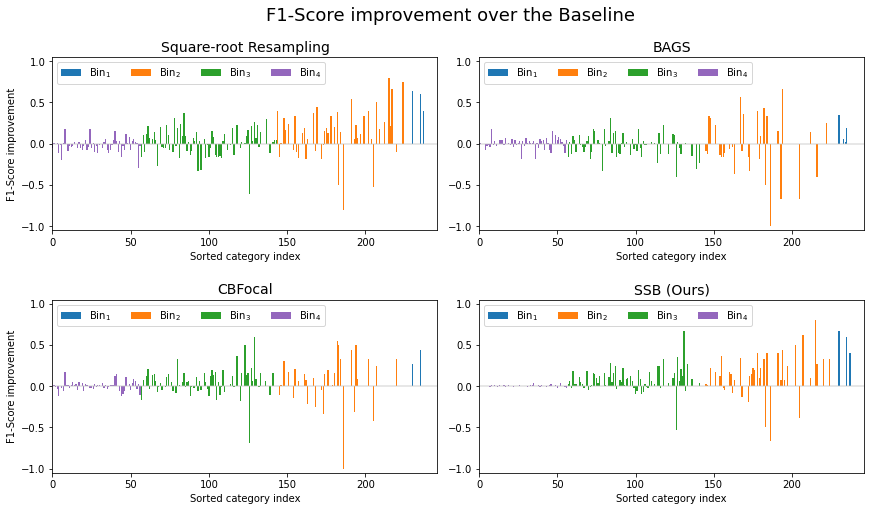

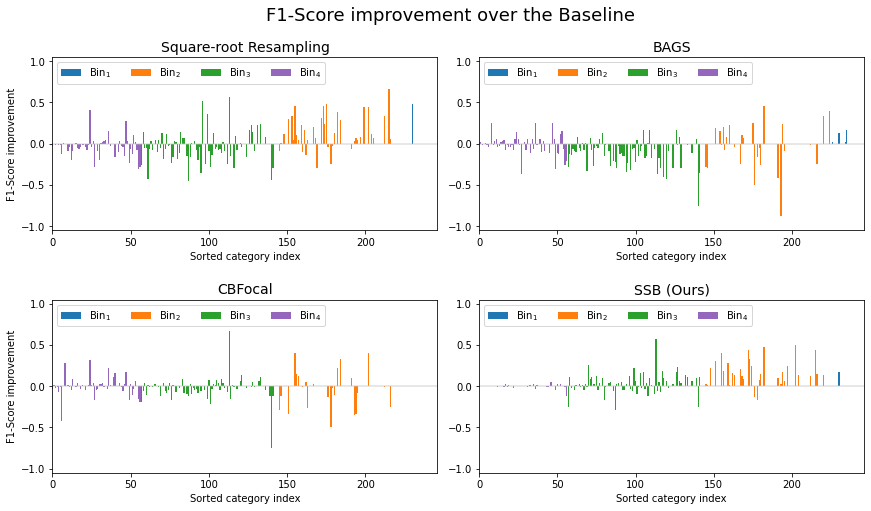

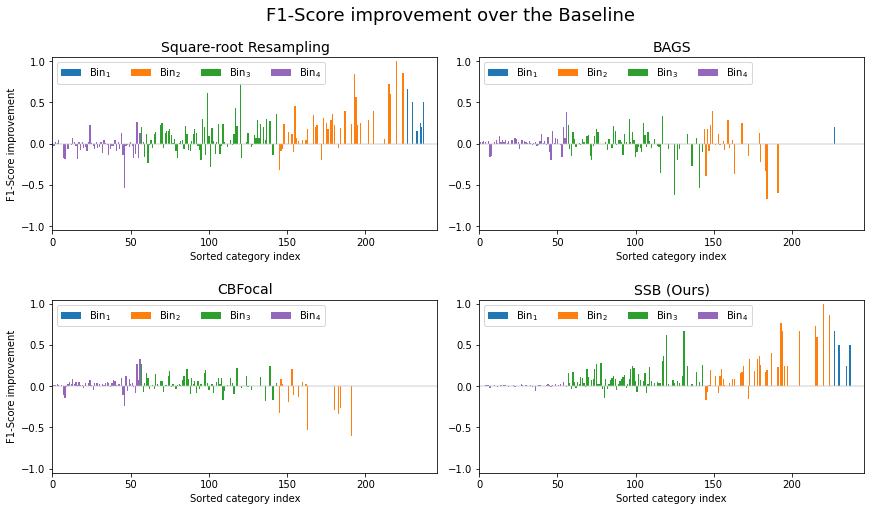

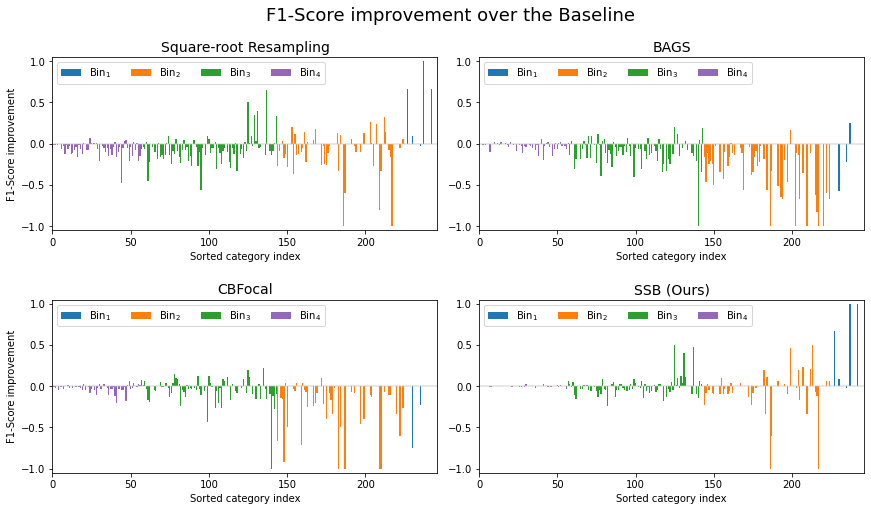

In [11]:
plot_all_f1(results, wcs_counts, 'WCS', 'Resnet50', '../data/wcs_fullimage_f1_resnet.pdf')
plot_all_f1(results, wcs_counts, 'WCS', 'MobileNetV3Large', '../data/wcs_fullimage_f1_mbnet.pdf')
plot_all_f1(results, wcs_counts, 'WCS', 'EfficientNetV2-B2', '../data/wcs_fullimage_f1_effv2b2.pdf')
plot_all_f1(results, wcs_counts, 'WCS', 'Swin-S','../data/wcs_fullimage_f1_swin.pdf')

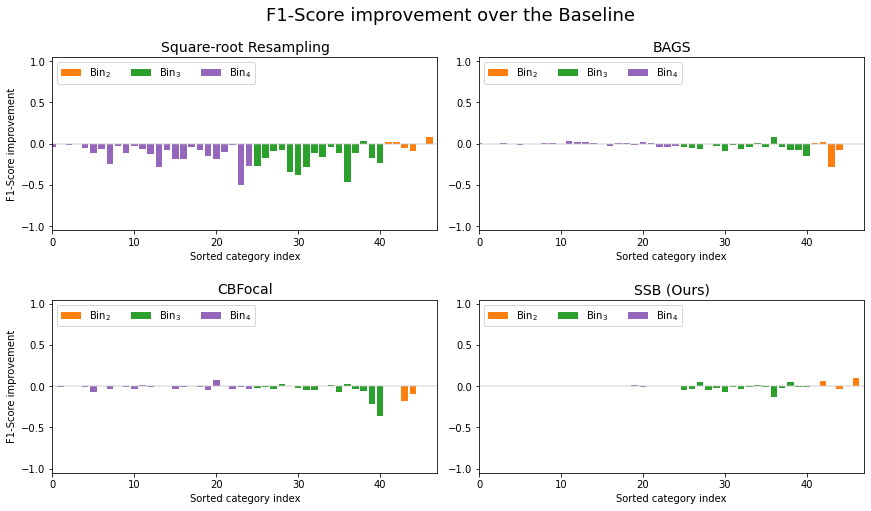

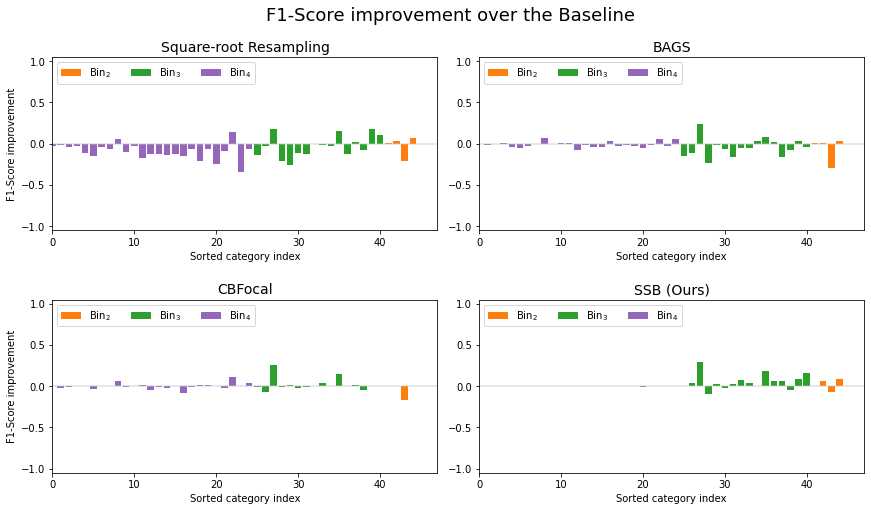

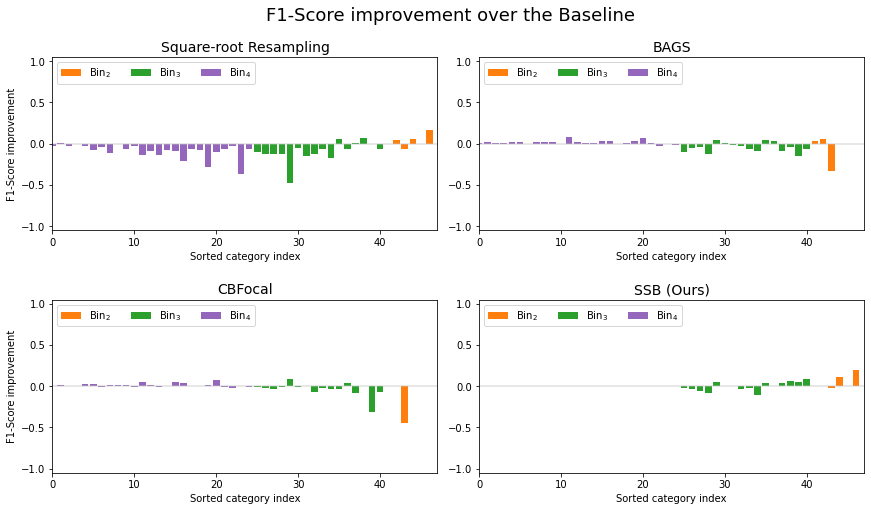

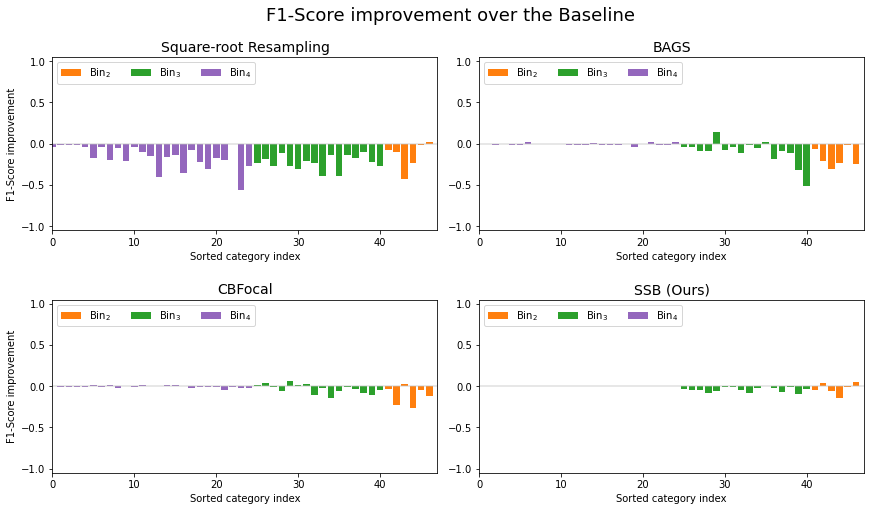

In [12]:
plot_all_f1(results, ss_counts, 'SS', 'Resnet50', '../data/ss_fullimage_f1_resnet.pdf')
plot_all_f1(results, ss_counts, 'SS', 'MobileNetV3Large', '../data/ss_fullimage_f1_mbnet.pdf')
plot_all_f1(results, ss_counts, 'SS', 'EfficientNetV2-B2', '../data/ss_fullimage_f1_effv2b2.pdf')
plot_all_f1(results, ss_counts, 'SS', 'Swin-S','../data/ss_fullimage_f1_swin.pdf')

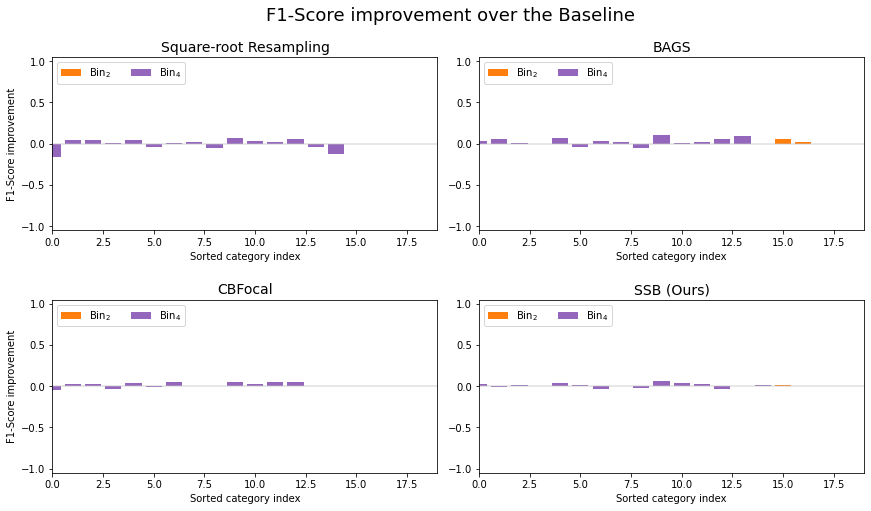

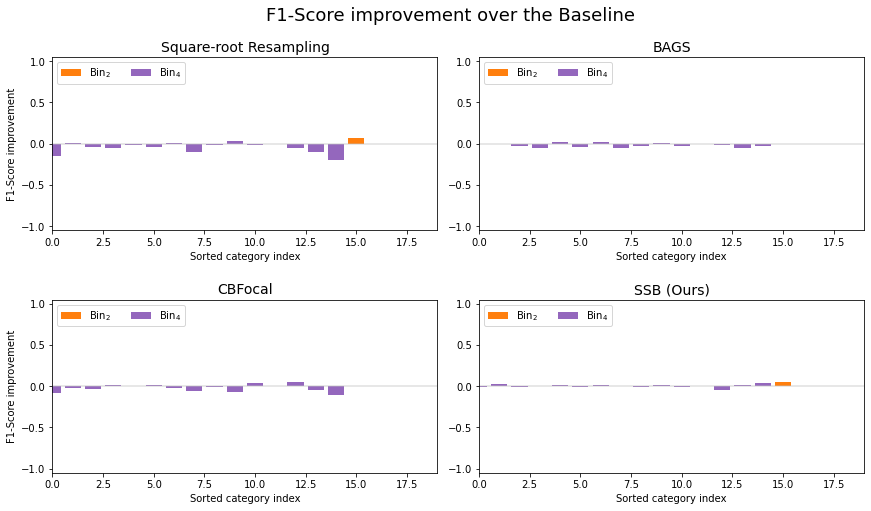

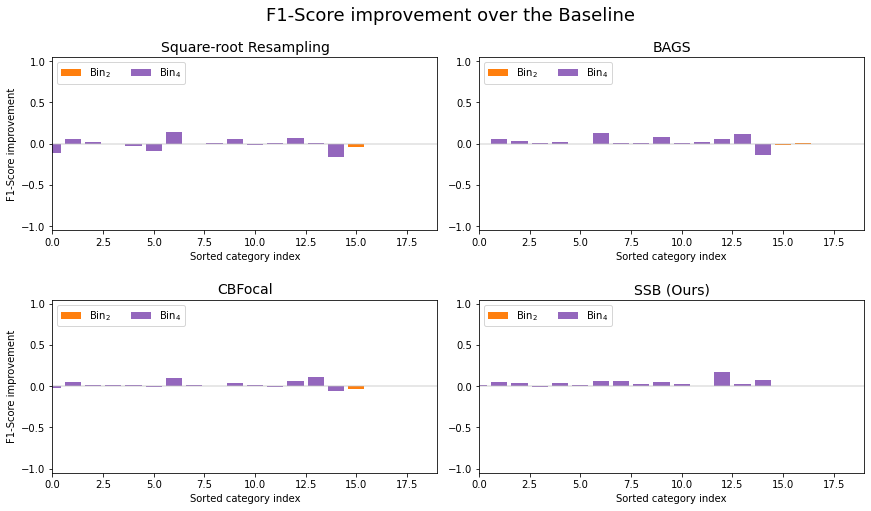

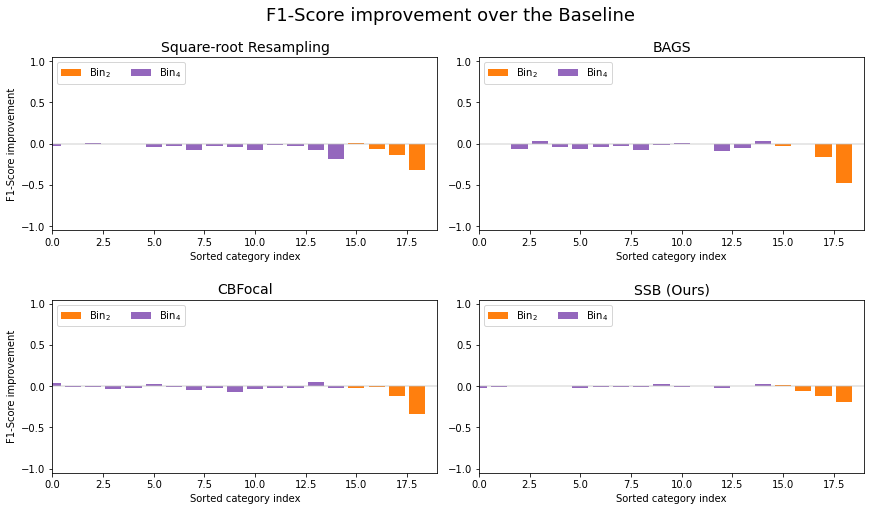

In [13]:
plot_all_f1(results, caltech_counts, 'Caltech', 'Resnet50', '../data/caltech_fullimage_f1_resnet.pdf')
plot_all_f1(results, caltech_counts, 'Caltech', 'MobileNetV3Large', '../data/caltech_fullimage_f1_mbnet.pdf')
plot_all_f1(results, caltech_counts, 'Caltech', 'EfficientNetV2-B2', '../data/caltech_fullimage_f1_effv2b2.pdf')
plot_all_f1(results, caltech_counts, 'Caltech', 'Swin-S','../data/caltech_fullimage_f1_swin.pdf')

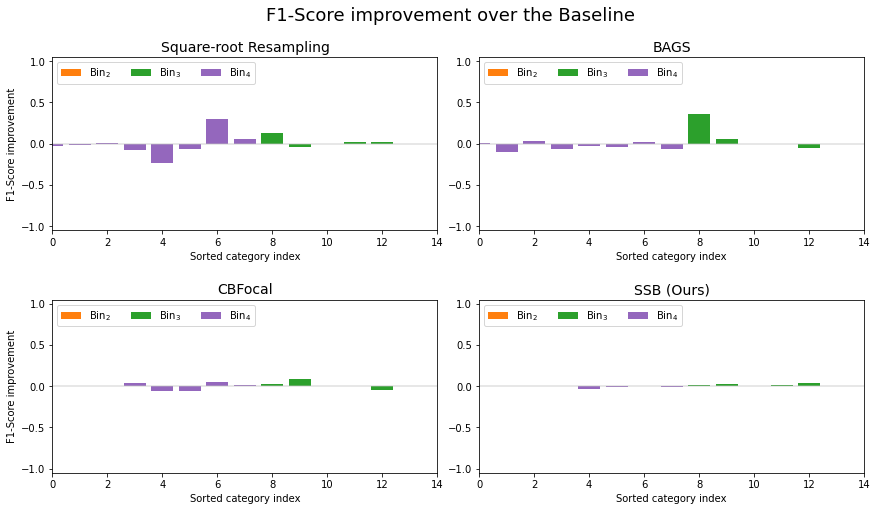

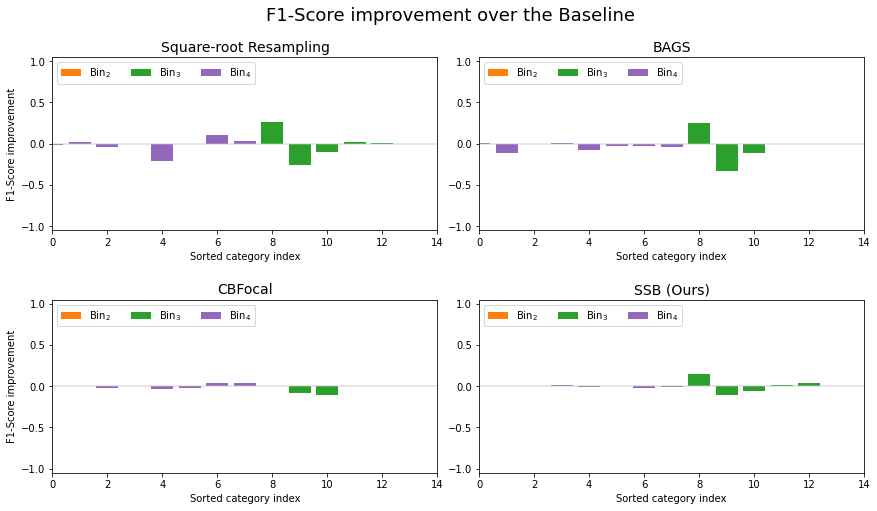

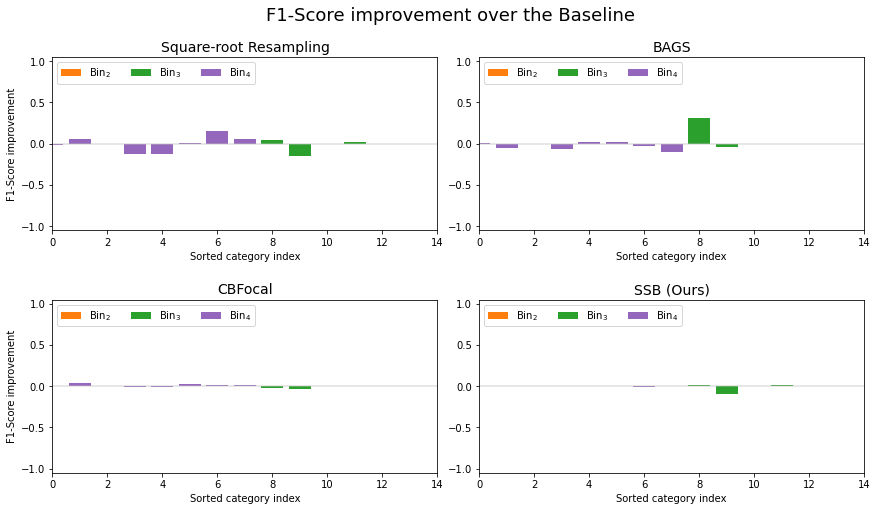

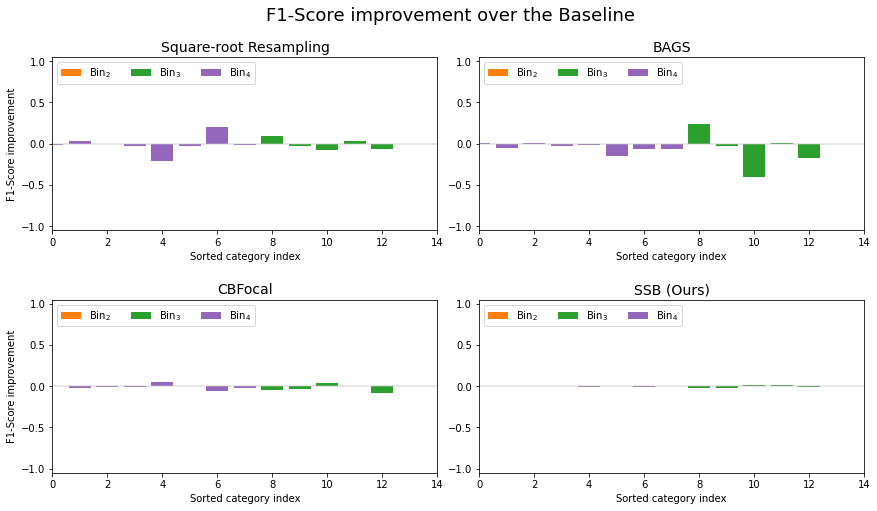

In [14]:
plot_all_f1(results, wel_counts, 'Wellington', 'Resnet50', '../data/wellington_fullimage_f1_resnet.pdf')
plot_all_f1(results, wel_counts, 'Wellington', 'MobileNetV3Large', '../data/wellington_fullimage_f1_mbnet.pdf')
plot_all_f1(results, wel_counts, 'Wellington', 'EfficientNetV2-B2', '../data/wellington_fullimage_f1_effv2b2.pdf')
plot_all_f1(results, wel_counts, 'Wellington', 'Swin-S','../data/wellington_fullimage_f1_swin.pdf')